In [1]:
import os
import sys

# change working directory
current_dir = os.getcwd() 
print(f"Current Working Directory: {current_dir}")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")
#We need to be in the main directory that contains tests, models, etc folders

Current Working Directory: /mnt/c/Users/ASUS/OneDrive - SISSA/study/research/primordial magnetic fields/wimp annihilation PMFs/python code/githubcode/tests
Current Working Directory: /mnt/c/Users/ASUS/OneDrive - SISSA/study/research/primordial magnetic fields/wimp annihilation PMFs/python code/githubcode


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from background import a_rec, a_T,BIkI_fromPT, kdsolve,evolution_BK, l_nuD, Ht, photon_mfp_full, l_gammaD, alpha, cb2_full
from power_spectra import F_int, table

In [3]:
# Define the phase transition temperature (T_PT) in MeV
T_PT = 100000  # Example value, adjust as needed
a_PT=a_T(T_PT) #scale factor at T_PT

# Get the evolution functions for B and K
# [B_evolve, k_evolve] = evolution_BK(T_PT, F_int)

[B_K,a_I]=BIkI_fromPT(T_PT) #B_K gives B and K as a function of scale factor
[BI,kI]= B_K(a_I)  # Get initial values of B and K at a_I
[kd, B_ev] = kdsolve(BI, kI, F_int)  # Get evolution of kd and B0

def B_evolve(a):
    if a < a_I:
        return B_K(a)[0]
    else:
        return B_ev(a)
def k_evolve(a):
    if a < a_I:
        return B_K(a)[1]
    else:
        return min(kI,kd.sol(a)[0])

In [4]:
# Define the range of scale factors (a) for the plot
a_values = np.logspace(np.log10(a_PT), 0, 500)  # From 10^-9 to 1 (today)

# Compute B and 1/K for the range of a
B_values = np.array([B_evolve(a).item() if isinstance(B_evolve(a), np.ndarray) else B_evolve(a) for a in a_values], dtype=float)  # Ensure B_values is a flat array
K_values = np.array([k_evolve(a).item() if isinstance(k_evolve(a), np.ndarray) else k_evolve(a) for a in a_values], dtype=float)  # Ensure K_values is a flat array
inverse_K_values = [1 / K for K in K_values]

# Compute additional quantities for the plot with 1/K
l_nuD_values = [l_nuD(a) for a in a_values]
inverse_a_H_values = [1 / (a * Ht(a)) for a in a_values]
l_gammaD_values = [l_gammaD(a) for a in a_values]
photon_mfp_values = [ photon_mfp_full(a) for a in a_values]
ther_pressure_scale=table(lambda a: a**2*Ht(a)*(Ht(a)+alpha(a))/cb2_full(a),a_values)**-0.5

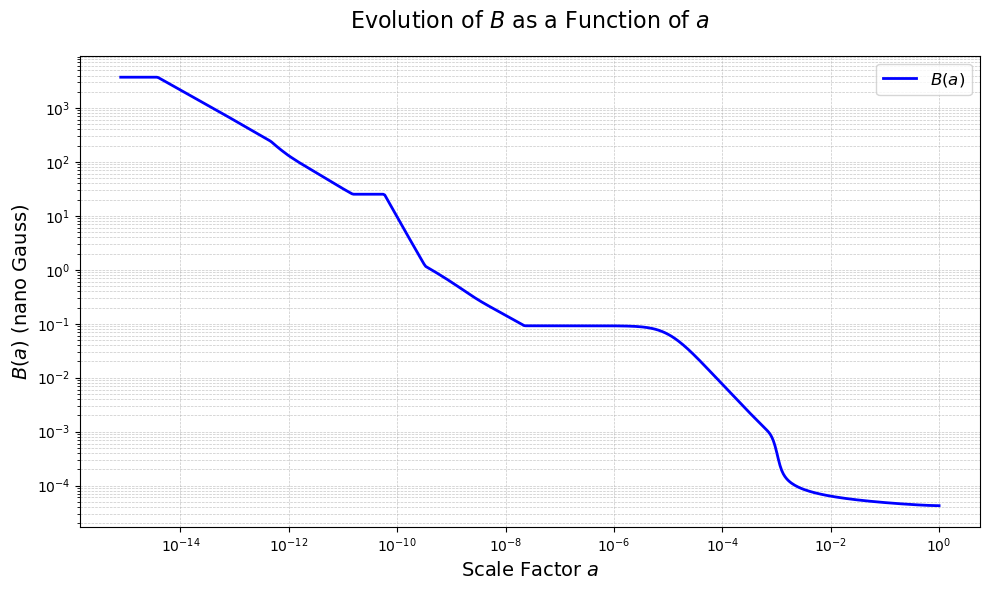

In [5]:
# Plot B as a function of a
plt.figure(figsize=(10, 6))
plt.loglog(a_values, B_values, label=r"$B(a)$", color="blue", linewidth=2)
plt.xlabel(r"Scale Factor $a$", fontsize=14)
plt.ylabel(r"$B(a)$ (nano Gauss)", fontsize=14)
plt.legend(fontsize=12, loc="best", frameon=True)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.title(r"Evolution of $B$ as a Function of $a$", fontsize=16, pad=20)
plt.tight_layout()
# plt.savefig("B_evolution.pdf", format="pdf", bbox_inches="tight")

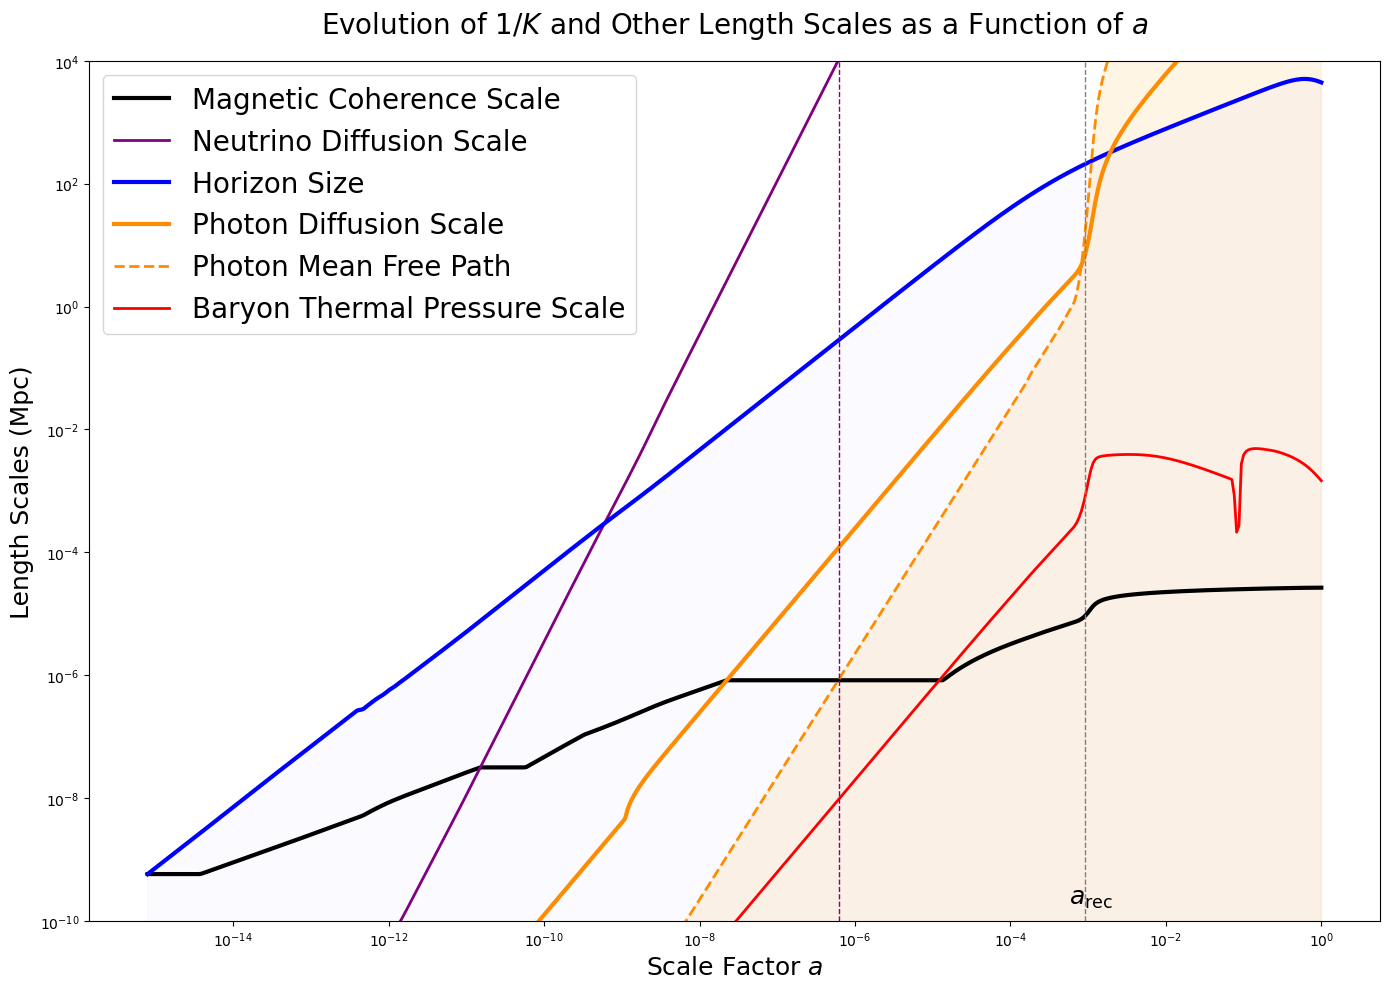

In [6]:
plt.figure(figsize=(14, 10))
plt.loglog(a_values, inverse_K_values, label=r"Magnetic Coherence Scale", color="k", linewidth=3)
plt.loglog(a_values, l_nuD_values, label=r"Neutrino Diffusion Scale", color="purple", linewidth=2)
plt.loglog(a_values, inverse_a_H_values, label=r"Horizon Size", color="blue", linewidth=3)
plt.loglog(a_values, l_gammaD_values, label=r"Photon Diffusion Scale", color="darkorange", linewidth=3)
plt.loglog(a_values, photon_mfp_values, label=r"Photon Mean Free Path", color="darkorange", linestyle="--", linewidth=2)
plt.loglog(a_values, ther_pressure_scale, label=r"Baryon Thermal Pressure Scale", color="red", linewidth=2)

# Shade the region below photon mean free path
plt.fill_between(a_values, plt.ylim()[0], photon_mfp_values, color="orange", alpha=0.1,)

# Shade the region below horizon size
plt.fill_between(a_values, plt.ylim()[0], inverse_a_H_values, color="blue", alpha=0.02, )

plt.ylim([10**-10, 10**4])
plt.xlabel(r"Scale Factor $a$", fontsize=18)
plt.ylabel(r"Length Scales (Mpc)", fontsize=18)
plt.legend(fontsize=20, loc="upper left", frameon=True)
# plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Find the intersection point where photon mean free path becomes larger than inverse_K_values
intersection_index = next((i for i, (mfp, inv_K) in enumerate(zip(photon_mfp_values, inverse_K_values)) if mfp > inv_K), None)
if intersection_index is not None:
    intersection_a = a_values[intersection_index]
    plt.axvline(intersection_a, color="purple", linestyle="--", linewidth=1)

# Draw vertical lines at the intersection and at a_rec
plt.axvline(a_rec, color="gray", linestyle="--", linewidth=1)
plt.text(1.2*a_rec, plt.ylim()[0] * 1.5, r"$a_{\rm rec}$", color="k", fontsize=18, ha="center", va="bottom", rotation=0)

plt.title(r"Evolution of $1/K$ and Other Length Scales as a Function of $a$", fontsize=20, pad=20)
plt.tight_layout()